#Translation - T5

T5X následovník T5, nefunkční:
*   Neúplná a nepřehledná [dokumentace T5X](https://t5x.readthedocs.io/en/latest/usage/infer-files.html#step-1-choose-a-model)
*   Google Cloud Storage - problémy s autentizací - placené úložiště, nefunkční načtení předtrénovaných modelů z GCS
* Chybějící spouštěcí modul: *infer_unfragmented*




####Tento notebook se zabývá převodem textu z jednoho jazyka do druhého na základě námi vytrénovaného nebo již předtrénovaného modelu T5 s využitím datasetu, na kterém byl model natrénovaný.

***Knihovna T5 slouží k načítání, předzpracování, kombinování a evaluaci datových sad. Poskytuje také možnost dotrénovat (fine-tune) předtrénované modely.Využíváme knihovny, které umožňují přístup k předtrénovaným modelům a datasetům na platformě HuggingFace.***

*Knihovna může být využita pro budoucí vývoj modelů poskytováním užitečných modulů pro trénování a dotrénování (potenciálně rozsáhlých) modelů na bázi text-to-text úloh.*

- Odkaz na využívaný repozitář:
[Repozitář](https://github.com/google-research/text-to-text-transfer-transformer.git)

- Návod Hugging Face: [HuggingFace](https://huggingface.co/docs/transformers/tasks/translation?fbclid=IwAR13_un46roXn_ggkjeiqQFovRYmKVyeOpGFLDstlGRYZHzm14CQqpCnnJ4)

- Dataset HuggingFace: [Dataset - OPUS books](https://huggingface.co/datasets/opus_books/viewer/en-fr/)

### 1. Instalace potřebných packages

*   **transformers** - knihovna od HuggingFace poskytuje přístup k předtrénovaným modelům pro zpracování přirozeného jazyka, včetně modelů z rodiny Transformer, jako je např. **T5**, BERT nebo GPT
*   **datasets** - poskytuje přístup k mnoha datasetům pro zpracování přirozeného jazyka, obsahuje funkce pro načítání, předzpracování a práci s různými datovými sadami, což zjednodušuje experimentování s různými daty
*   **evaluate** - pro vyhodnocování výsledků modelu, v tomto kontextu obsahuje kód pro vyhodnocování kvality překladů nebo výkonu modelu na konkrétní úloze
*   **sacrebleu** - používán pro vyhodnocování přesnosti překladů v kontextu práce s překladatelskými modely





In [ ]:
! pip install transformers datasets evaluate sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00


##Zobrazení obsahu datasetu

###Funkce *load_dataset* slouží k načtení datové sady ***opus_books*** v jazykovém páru angličtina–francouzština ("en-fr").



In [ ]:
from datasets import load_dataset #načítání různých datových sad pro práci se zpracováním přirozeného jazyka

books = load_dataset("opus_books", "en-fr") #načtení datové sady "opus_books" pro překlad z angličtiny do francouzštiny

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

Rozdělení trénovacích dat (uložených v *books["train"]*) na dvě části: novou trénovací část a testovací část. Tato práce s testovací množinou je užitečná při evaluaci modelu, protože umožňuje ověřit jeho schopnost generalizace na neznámá data.

In [ ]:
books = books["train"].train_test_split(test_size=0.2) #rozdělení datové sady na trénovací a testovací množiny - argument testsize=0.2 = 20% train a 20% test

In [ ]:
books["train"][0]

{'id': '106724',
 'translation': {'en': 'Some pipes full of opium lay upon the table.',
  'fr': "Sur la table se trouvaient quelques pipes chargées d'opium."}}

####Přístup k předtrénovanému tokenizeru pro model T5:
Třída *AutoTokenizer* slouží k načtení předtrénovaného tokenizeru pro model T5.
Získáme přístup k předtrénovanému tokenizeru pro model T5 (t5-small). Tento tokenizer můžeme následně používat **k převodu textu na tokeny - obvyklý krok před vstupem do modelu.**






In [ ]:
from transformers import AutoTokenizer

checkpoint = "t5-small" # checkpoint = předtrénovaný model
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

###**Předzpracování dat**

#####Po provední této operace bude každý příklad obsahovat tokeny vstupů a cílů, které jsou pak připravené pro vstup do modelu.

In [ ]:
source_lang = "en" #zdrojový jazyk
target_lang = "fr" #cílový jazyk
prefix = "translate English to French: "

#tato funkce přijímá slovník příkladů (např., trénovací nebo testovací data) a vrací připravená data pro model
def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]] #seznam vstupů pro model-pro každý příklad v datovém slovníku přidává prefix a kombinuje ji s anglickým textem
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True) #tokenizer-převod vstupních a cílových textů na tokeny
    # max_length=128,truncation=True = omezení délky vstupu na max. 128 tokenů a provedení oříznutí textu - pokud přesáhne tuto délku
    return model_inputs

In [ ]:
tokenized_books = books.map(preprocess_function, batched=True)

Map:   0%|          | 0/101668 [00:00<?, ? examples/s]

Map:   0%|          | 0/25417 [00:00<?, ? examples/s]

**Funkce preprocess** předzpracovává jednotlivé příklady datové sady - pro každý příklad vytváří vstup pro model pomocí tokenizeru. Výsledek funkce obsahuje ***tokeny vstupů a cílů pro každý příklad***

**Metoda map** aplikuje funkci preprocess_function na každý prvek datové sady.

**Parametr batched=True** - funkce preprocess_function ***bude aplikována na dávky dat najednou***, je to efektivní při práci s velkými datovými sadami.

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint, return_tensors="tf")
#return_tensors="tf" - výstupní data mají být ve formátu TensorFlow tenzorů -> TensorFlow knihovna

Třída **DataCollatorForSeq2Seq** slouží k vytváření objektu, který dokáže zpracovat data pro trénování nebo vyhodnocování modelů.

##**Evaluate (vyhodnocení)**

####**Evaluate = vyhodnocování - proces posuzování výkonu modelu na testovacích datech.**

####Načtení metriky sacrebleu pro hodnocení kvality:

In [ ]:
import evaluate

metric = evaluate.load("sacrebleu") #načtení metriky s názvem sacrebleu -> hodnocení kvality strojových překladů

Funkce **postprocess_text** a **compute_metrics** slouží k postprocessingu (proces úprav nebo manipulace s daty) a výpočtu metrik na výsledcích vyhodnocování modelu, zejména v kontextu překladu textu.

In [ ]:
import numpy as np #knihovna pro práci s vícerozměrnými poli (např. matice nebo tenzory)


def postprocess_text(preds, labels):            #funkce přijímá predikce (preds) a skutečné hodnoty (labels)
    preds = [pred.strip() for pred in preds]          #odstranění mezer na začátku a konci -> výstup ve formátu seznamu
                                                      #preds = odhady nebo generovaný text, který model vytvořil v odpovědi na vstupní text
    labels = [[label.strip()] for label in labels]    #labels = překlady ve skutečném cílovém jazyce

    return preds, labels


def compute_metrics(eval_preds):        #přijímá vyhodnocené předpovědi (eval_preds) - obsahují preds a labels
    preds, labels = eval_preds          #rozbalení vyhodnocených předpovědí
    if isinstance(preds, tuple):        #ověření, zda jsou preds ve formě seznamu, pokud ano, vezme se první element a slouží k zajištění toho, že preds obsahuje hlavní výstupy modelu, které budou následně dekódovány a použity pro výpočet metrik
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True) #dekódování modelových výstupů z tokenů->text pomocí tokenizeru; speciální tokeny jsou přeskakovány (skip_special_tokens=True).

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id) #nahrazení hodnoty -100 v labels tokenem pro vyplnění (pad token) z tokenizeru.
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True) #dekódování skutečných hodnot (labels) z tokenů -> text

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels) #funkce postprocess_text pro další úpravy dekódovaných preds a labels

    result = metric.compute(predictions=decoded_preds, references=decoded_labels) #výpočet metrik na základě dekódovaných preds a labels
    result = {"bleu": result["score"]} #uložení výsledku metriky BLEU do result

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds] #výpočet délky generovaných předpovědí bez použití tokenů pro vyplnění (pad token)
    result["gen_len"] = np.mean(prediction_lens) # uložení průměrné délky generovaných předpovědí do slovníku result
    result = {k: round(v, 4) for k, v in result.items()} #zaokrouhlování výsledných hodnot na čtyři desetinná místa
    return result



##**Příklad dotrénování modelu (fine-tune)**

In [ ]:
from transformers import AdamWeightDecay

optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)

**Learning_rate** (rychlost učení) určuje jak rychle se model učí během tréninku a jak velké kroky dělá při aktualizaci svých váh.

**Weight_decay_rate** (váhový útlum) zabrání tomu, aby se váhy modelu potenciálně přizpůsobily trénovacím datům až příliš.

In [ ]:
from transformers import TFAutoModelForSeq2SeqLM

model = TFAutoModelForSeq2SeqLM.from_pretrained(checkpoint) #checkpoint = název předtrénovaného modelu

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


 **Třída TFAutoModelForSeq2SeqLM** představuje architekturu modelu pro sekvenční generaci v našem případě pro překlad.

 **Metoda from_pretrained** načítá váhy (weights) a konfiguraci modelu z předtrénované verze.

In [ ]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_books["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_books["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


**Metoda model.prepare_tf_dataset** připravuje TensorFlow dataset, bere tokenizovaná data (v tomto případě ze slovníku tokenized_books pro trénovací a testovací množinu), specifikuje různé parametry, jako je míchání (shuffle), velikost dávky (batch_size) a funkce pro zpracování dat (collate_fn).

In [ ]:
import tensorflow as tf

model.compile(optimizer=optimizer)  # No loss argument!

**Metoda compile** slouží pro kompilaci modelu v TensorFlow, obvykle se používá v kontextu tréninku modelu a slouží k nastavení několika důležitých parametrů, včetně optimalizačního algoritmu.

#### **Nahrání modelu na HuggingFace*

In [ ]:
from transformers.keras_callbacks import PushToHubCallback

push_to_hub_callback = PushToHubCallback(
    output_dir="my__model",
    tokenizer=tokenizer,
)

In [ ]:
callbacks = [metric_callback, push_to_hub_callback]

###Spuštění tréninku

Metoda **fit** provede trénink modelu na trénovacích datech (tf_train_set) po určený počet epoch a vyhodnotí model na testovacích datech (tf_test_set) po každé doběhnuté epoše.

In [ ]:
model.fit(x=tf_train_set, validation_data=tf_test_set, epochs=3, callbacks=callbacks)

##**Otestování funkčnosti předtrénovaného modelu T5-small**

###Připravíme si vstupní text, tokenizujeme ho, použijeme model pro generaci překladu a následně dekódujeme výsledek zpět do lidsky čitelné podoby.

##**Model T5-small**:

####[T5-small](https://huggingface.co/t5-small) je předtrénovaný model s 60 miliony parametry sloužící k převodu text-to-text formátu ke zpracování přirozeného jazyka (NLP) do jiného cílového jazyka.

*   Velikost modelu: 60,5 milionu parametrů
*   [Dataset C4](https://huggingface.co/datasets/c4)
*   English, French, Romanian, German



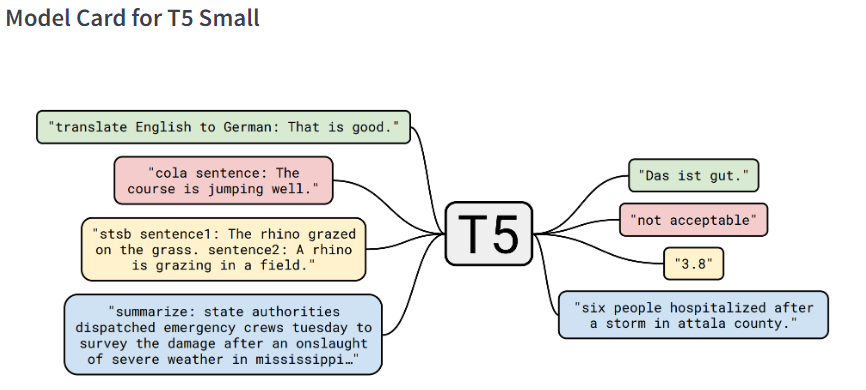

### **Překlad:**

In [ ]:
text = input("translate English to French: ")

print("Enter the text you want to translate:", text)


translate English to French: Hello, how are you today?
Enter the text you want to translate: Hello, how are you today?


Nástroj **pipeline** umožňuje jednoduchý přístup k předtrénovaným modelům pro různé úlohy, v našem případě pro překlad.

In [ ]:
from transformers import pipeline
translator = pipeline("translation", model="t5-small")
input_text = f"translate English to French: {text}"
result = translator(input_text)
output = {'inputs': input_text, 'targets': result[0]['translation_text']}

print(output)

{'inputs': 'translate English to French: Hello, how are you today?', 'targets': "Bonjour, comment êtes-vous aujourd'hui?"}


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-small")
inputs = tokenizer(text, return_tensors="tf").input_ids

Vytvoření tokenizeru pro model "t5-small" a používá se k tokenizaci anglického textu (text). **Identifikátory tokenů** jsou uloženy v proměnné **inputs**.

In [ ]:
inputs

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[8774,    6,  149,   33,   25,  469,   58,    1]], dtype=int32)>

Vygenerujeme **sekvenci tokenů** pomocí modelu pro sekvenční generaci "t5-small" na základě zadaných identifikátorů tokenů (inputs). Výsledek je uložen v proměnné outputs.

In [ ]:
from transformers import TFAutoModelForSeq2SeqLM

model = TFAutoModelForSeq2SeqLM.from_pretrained("t5-small")
outputs = model.generate(inputs, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [ ]:
outputs #identifikátory tokenů

<tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[   0, 2501, 8774,    6,  587,  436,  292, 4270,   58,    1]],
      dtype=int32)>


Dekódování výstupu modelu zpět do čitelného textu:

In [ ]:
tokenizer.decode(outputs[0], skip_special_tokens=True)

'Hall Hello, wie sind Sie heute?'